In [1]:
import sys

sys.path.insert(0, '..')

In [12]:
from __future__ import annotations

import numpy as np
import librosa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [13]:
sample_rate = 16000

# 512 important here for speech processing, ~23ms for our data from Libriparty
windowed_signal_length = 512
num_mel_bands = 40

ys, _ = librosa.load(path='LibriParty\dataset\dev\session_0\session_0_mixture.wav', sr=sample_rate)

fft_frame shape: (257, 36884)
mfsc shape: (40, 36884)


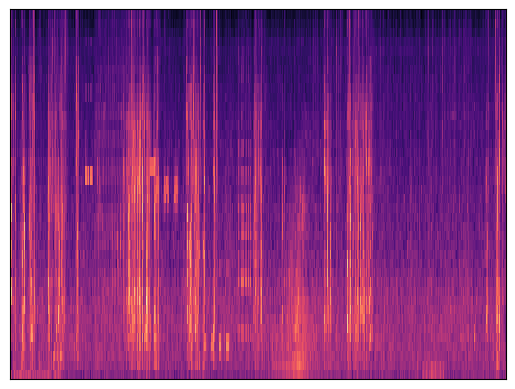

In [ ]:
def compute_mfsc(ys, windowed_signal_length, sample_rate):
    fft_frames = librosa.stft(y=ys, n_fft=windowed_signal_length)
    print(f'fft_frame shape: {fft_frames.shape}')
    power_spectrum = np.abs(fft_frames) ** 2

    mel_filterbank = librosa.filters.mel(sr=sample_rate, n_fft=windowed_signal_length, n_mels=num_mel_bands)
    mel_energies = np.dot(mel_filterbank, power_spectrum)
    mfsc = np.log(mel_energies + 1e-10)
    return mfsc

mfsc = compute_mfsc(ys, windowed_signal_length, sample_rate)
print(f'mfsc shape: {mfsc.shape}')

librosa.display.specshow(mfsc)


In [5]:
model = nn.Sequential()

# convolutional layer 1
model.add_module(name='conv1', module=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
model.add_module(name='relu1', module=nn.ReLU())
model.add_module(name='pool1', module=nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', module=nn.Dropout(p=.5))

model.add_module(name='conv2', module=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module(name='relu2', module=nn.ReLU())
model.add_module(name='pool2', module=nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', module=nn.Dropout(p=.5))

model.add_module(name='conv3', module=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', module=nn.ReLU())        
model.add_module('pool3', module=nn.MaxPool2d(kernel_size=2))   

model.add_module(name='conv4', module=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module(name='relu4', module=nn.ReLU())

In [6]:
x = torch.ones(32, 1, 40, 40)
model(x).shape
print(f'Model output dimensions before flattening: {model(x).shape}')

model.add_module(name='pool4', module=nn.AvgPool2d(kernel_size=5))
model.add_module(name='flatten', module=nn.Flatten())

print(f'Model after pooling and flattening: {model(x).shape}')

model.add_module(name='fc', module=nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=nn.Sigmoid())

print(f'Model shape after fully connected layer and eventual output: {model(x).shape}')
print(f'Model architecture:\n {model}')

Model output dimensions before flattening: torch.Size([32, 256, 5, 5])
Model after pooling and flattening: torch.Size([32, 256])
Model shape after fully connected layer and eventual output: torch.Size([32, 1])
Model architecture:
 Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_s

In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

batch_size = 32

In [8]:
train_ds = torch.load("train_ds.pt", weights_only=False)
valid_ds = torch.load("valid_ds.pt", weights_only=False)
test_ds = torch.load("test_ds.pt", weights_only=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [9]:
def train():
    num_epochs = 20
    train_acc_hist = [0.0] * num_epochs
    valid_acc_hist = [0.0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            # if x_batch.shape != (batch_size, 1, num_mel_bands, num_mel_bands):
            #     print(f'x_batch has wrong shape: {x_batch.shape}')
            #     assert False

            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            is_correct = ((pred >= .5).float() == y_batch).float()
            train_acc_hist[epoch] += is_correct.sum()
        train_acc_hist[epoch] /= len(train_dl.dataset)
                
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                is_correct = ((pred>=0.5).float() == y_batch).float()
                valid_acc_hist[epoch] += is_correct.sum()
        valid_acc_hist[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} Training acc: {train_acc_hist[epoch]:.4f} Validation acc: {valid_acc_hist[epoch]:.4f}')
    return train_acc_hist, valid_acc_hist

In [10]:
torch.manual_seed(1)
train_acc_hist, valid_acc_hist = train()

Epoch 1 Training acc: 0.8754 Validation acc: 0.8981
Epoch 2 Training acc: 0.8934 Validation acc: 0.9022
Epoch 3 Training acc: 0.9002 Validation acc: 0.9060
Epoch 4 Training acc: 0.9053 Validation acc: 0.9051
Epoch 5 Training acc: 0.9085 Validation acc: 0.9126
Epoch 6 Training acc: 0.9109 Validation acc: 0.9144
Epoch 7 Training acc: 0.9125 Validation acc: 0.9155
Epoch 8 Training acc: 0.9140 Validation acc: 0.9024
Epoch 9 Training acc: 0.9142 Validation acc: 0.9014
Epoch 10 Training acc: 0.9161 Validation acc: 0.9072
Epoch 11 Training acc: 0.9172 Validation acc: 0.9141
Epoch 12 Training acc: 0.9172 Validation acc: 0.9153
Epoch 13 Training acc: 0.9179 Validation acc: 0.9074
Epoch 14 Training acc: 0.9183 Validation acc: 0.9176
Epoch 15 Training acc: 0.9187 Validation acc: 0.9120
Epoch 16 Training acc: 0.9196 Validation acc: 0.9013
Epoch 17 Training acc: 0.9201 Validation acc: 0.9158
Epoch 18 Training acc: 0.9203 Validation acc: 0.9158
Epoch 19 Training acc: 0.9204 Validation acc: 0.9070
Ep

In [11]:
model.eval()
test_acc = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        test_acc += is_correct.sum()
test_acc /= len(valid_dl.dataset)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.9208552241325378


In [15]:
torch.save(model, 'trained_model.pth')